# Autonomous Driving - Car Detection

**RECAP**:

- Detect objects in a car detection dataset
- Implement non-max suppression to increase accuracy
- Implement intersection over union
- Handle bounding boxes, a type of image annotation popular in deep learning

In [16]:
import argparse
import os
import matplotlib.pyplot as plt
from matplotlib.pyplot import imshow
import scipy.io
import scipy.misc
import numpy as np
import pandas as pd
import PIL
from PIL import ImageFont, ImageDraw, Image
import tensorflow as tf
from tensorflow.keras.models import load_model
from yad2k.models.keras_yolo import yolo_head
from yad2k.utils.utils import draw_boxes, get_colors_for_classes, scale_boxes, read_classes, read_anchors, preprocess_image

%matplotlib inline

### Filtering with a Threshold on Class Scores

We're going to first apply a filter by thresholding, meaning you'll get rid of any box for which the class "score" is less than a chosen threshold. 

In [17]:
def yolo_filter_boxes(boxes, box_confidence, box_class_probs, threshold = 0.6):
    """Filters YOLO boxes by thresholding on object and class confidence.
    
    Arguments:
        boxes -- tensor of shape (19, 19, 5, 4)
        box_confidence -- tensor of shape (19, 19, 5, 1)
        box_class_probs -- tensor of shape (19, 19, 5, 80)
        threshold -- real value, if [ highest class probability score < threshold],
                     then get rid of the corresponding box

    Returns:
        scores -- tensor of shape (None,), containing the class probability score for selected boxes
        boxes -- tensor of shape (None, 4), containing (b_x, b_y, b_h, b_w) coordinates of selected boxes
        classes -- tensor of shape (None,), containing the index of the class detected by the selected boxes

    Note: "None" is here because you don't know the exact number of selected boxes, as it depends on the threshold. 
    For example, the actual output size of scores would be (10,) if there are 10 boxes.
    """
    
    x = 10
    y = tf.constant(100)

    # Step 1: Compute box scores
 
    box_scores = box_class_probs*box_confidence
    
    # Step 2: Find the box_classes using the max box_scores, keep track of the corresponding score

    box_classes = tf.math.argmax(box_scores,axis=-1)
    box_class_scores = tf.math.reduce_max(box_scores,axis=-1)
    
    # Step 3: Create a filtering mask based on "box_class_scores" by using "threshold". The mask should have the
    # same dimension as box_class_scores, and be True for the boxes you want to keep (with probability >= threshold)

    filtering_mask = (box_class_scores >= threshold)
    
    # Step 4: Apply the mask to box_class_scores, boxes and box_classes

    scores = tf.boolean_mask(box_class_scores,filtering_mask)
    boxes = tf.boolean_mask(boxes,filtering_mask)
    classes = tf.boolean_mask(box_classes,filtering_mask)
    
    return scores, boxes, classes

### Non-max Suppression

Even after filtering by thresholding over the class scores, we still end up with a lot of overlapping boxes. A second filter for selecting the right boxes is called non-maximum suppression (NMS). 

Non-max suppression uses the very important function called **"Intersection over Union"**, or IoU.

In [18]:
def iou(box1, box2):
    """Implement the intersection over union (IoU) between box1 and box2
    
    Arguments:
    box1 -- first box, list object with coordinates (box1_x1, box1_y1, box1_x2, box_1_y2)
    box2 -- second box, list object with coordinates (box2_x1, box2_y1, box2_x2, box2_y2)
    """


    (box1_x1, box1_y1, box1_x2, box1_y2) = box1
    (box2_x1, box2_y1, box2_x2, box2_y2) = box2
    
    # Calculate the (yi1, xi1, yi2, xi2) coordinates of the intersection of box1 and box2. Calculate its Area.
    xi1 = max(box1_x1,box2_x1)
    yi1 = max(box1_y1,box2_y1)
    xi2 = min(box1_x2,box2_x2)
    yi2 = min(box1_y2,box2_y2)
    inter_width = max(0,yi2 - yi1)
    inter_height = max(0,xi2 - xi1)
    inter_area = inter_width*inter_height

    # Calculate the Union area by using Formula: Union(A,B) = A + B - Inter(A,B)
    box1_area = (box1_x2-box1_x1)*((box1_y2-box1_y1))
    box2_area = (box2_x2-box2_x1)*((box2_y2-box2_y1))
    union_area = box1_area + box2_area - inter_area
    
    # compute the IoU
    iou = inter_area/union_area
    
    return iou

In [19]:
def yolo_non_max_suppression(scores, boxes, classes, max_boxes = 10, iou_threshold = 0.5):
    """
    Applies Non-max suppression (NMS) to set of boxes
    
    Arguments:
    scores -- tensor of shape (None,), output of yolo_filter_boxes()
    boxes -- tensor of shape (None, 4), output of yolo_filter_boxes() that have been scaled to the image size (see later)
    classes -- tensor of shape (None,), output of yolo_filter_boxes()
    max_boxes -- integer, maximum number of predicted boxes you'd like
    iou_threshold -- real value, "intersection over union" threshold used for NMS filtering
    
    Returns:
    scores -- tensor of shape (, None), predicted score for each box
    boxes -- tensor of shape (4, None), predicted box coordinates
    classes -- tensor of shape (, None), predicted class for each box
    
    Note: The "None" dimension of the output tensors has obviously to be less than max_boxes. Note also that this
    function will transpose the shapes of scores, boxes, classes. This is made for convenience.
    """
    
    max_boxes_tensor = tf.Variable(max_boxes, dtype='int32')     # tensor to be used in tf.image.non_max_suppression()
    
    # Use tf.image.non_max_suppression() to get the list of indices corresponding to boxes you keep
 
    nms_indices = tf.image.non_max_suppression(boxes,scores,max_boxes_tensor,iou_threshold)
    
    # Use tf.gather() to select only nms_indices from scores, boxes and classes

    scores = tf.gather(scores,nms_indices)
    boxes = tf.gather(boxes,nms_indices)
    classes = tf.gather(classes,nms_indices)
    
    return scores, boxes, classes

In [20]:
def yolo_boxes_to_corners(box_xy, box_wh):
    """Convert YOLO box predictions to bounding box corners."""
    box_mins = box_xy - (box_wh / 2.)
    box_maxes = box_xy + (box_wh / 2.)

    return tf.keras.backend.concatenate([
        box_mins[..., 1:2],  # y_min
        box_mins[..., 0:1],  # x_min
        box_maxes[..., 1:2],  # y_max
        box_maxes[..., 0:1]  # x_max
    ])

In [21]:
def yolo_eval(yolo_outputs, image_shape = (720, 1280), max_boxes=10, score_threshold=.6, iou_threshold=.5):
    

    """
    Converts the output of YOLO encoding (a lot of boxes) to your predicted boxes along with their scores, box coordinates and classes.
    
    Arguments:
    yolo_outputs -- output of the encoding model (for image_shape of (608, 608, 3)), contains 4 tensors:
                    box_xy: tensor of shape (None, 19, 19, 5, 2)
                    box_wh: tensor of shape (None, 19, 19, 5, 2)
                    box_confidence: tensor of shape (None, 19, 19, 5, 1)
                    box_class_probs: tensor of shape (None, 19, 19, 5, 80)
    image_shape -- tensor of shape (2,) containing the input shape, in this notebook we use (608., 608.) (has to be float32 dtype)
    max_boxes -- integer, maximum number of predicted boxes you'd like
    score_threshold -- real value, if [ highest class probability score < threshold], then get rid of the corresponding box
    iou_threshold -- real value, "intersection over union" threshold used for NMS filtering
    
    Returns:
    scores -- tensor of shape (None, ), predicted score for each box
    boxes -- tensor of shape (None, 4), predicted box coordinates
    classes -- tensor of shape (None,), predicted class for each box
    """
    
    
    # Retrieve outputs of the YOLO model (≈1 line)
    box_xy, box_wh, box_confidence, box_class_probs = yolo_outputs

    # Convert boxes to be ready for filtering functions (convert boxes box_xy and box_wh to corner coordinates)
    boxes = yolo_boxes_to_corners(box_xy, box_wh)

    # Use one of the functions you've implemented to perform Score-filtering with a threshold of score_threshold (≈1 line)
    scores, boxes, classes = yolo_filter_boxes(boxes, box_confidence, box_class_probs, score_threshold)
    
    # Scale boxes back to original image shape (720, 1280 or whatever)
    boxes = scale_boxes(boxes, image_shape) # Network was trained to run on 608x608 images

    # Use one of the functions you've implemented to perform Non-max suppression with 
    # maximum number of boxes set to max_boxes and a threshold of iou_threshold (≈1 line)
    scores, boxes, classes = yolo_non_max_suppression(scores, boxes, classes, max_boxes, iou_threshold)
    
    return scores, boxes, classes

## Test YOLO Pre-trained Model on Images

In this section, we are going to use a pre-trained model and test it on the car detection dataset.  

### Defining Classes, Anchors and Image Shape

We're trying to detect 80 classes, and are using 5 anchor boxes. The information on the 80 classes and 5 boxes is gathered in two files: "coco_classes.txt" and "yolo_anchors.txt". We'll read class names and anchors from text files. The car detection dataset has 720x1280 images, which are pre-processed into 608x608 images.

In [22]:
class_names = read_classes("model_data/coco_classes.txt")
anchors = read_anchors("model_data/yolo_anchors.txt")
model_image_size = (608, 608) # Same as yolo_model input layer size

### 3.2 - Loading a Pre-trained Model

Training a YOLO model takes a very long time and requires a fairly large dataset of labelled bounding boxes for a large range of target classes. We are going to load an existing pre-trained Keras YOLO model stored in "yolo.h5". These weights come from the official YOLO website.
Technically, these are the parameters from the "YOLOv2" model, but are simply referred to as "YOLO" in this notebook.

In [23]:
yolo_model = load_model("model_data/", compile=False)

In [24]:
yolo_model.summary()

Model: "functional_1"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 608, 608, 3  0           []                               
                                )]                                                                
                                                                                                  
 conv2d (Conv2D)                (None, 608, 608, 32  864         ['input_1[0][0]']                
                                )                                                                 
                                                                                                  
 batch_normalization (BatchNorm  (None, 608, 608, 32  128        ['conv2d[0][0]']                 
 alization)                     )                                                      

                                                                                                  
 batch_normalization_8 (BatchNo  (None, 38, 38, 512)  2048       ['conv2d_8[0][0]']               
 rmalization)                                                                                     
                                                                                                  
 leaky_re_lu_8 (LeakyReLU)      (None, 38, 38, 512)  0           ['batch_normalization_8[0][0]']  
                                                                                                  
 conv2d_9 (Conv2D)              (None, 38, 38, 256)  131072      ['leaky_re_lu_8[0][0]']          
                                                                                                  
 batch_normalization_9 (BatchNo  (None, 38, 38, 256)  1024       ['conv2d_9[0][0]']               
 rmalization)                                                                                     
          

 conv2d_20 (Conv2D)             (None, 38, 38, 64)   32768       ['leaky_re_lu_12[0][0]']         
                                                                                                  
 leaky_re_lu_18 (LeakyReLU)     (None, 19, 19, 1024  0           ['batch_normalization_18[0][0]'] 
                                )                                                                 
                                                                                                  
 batch_normalization_20 (BatchN  (None, 38, 38, 64)  256         ['conv2d_20[0][0]']              
 ormalization)                                                                                    
                                                                                                  
 conv2d_19 (Conv2D)             (None, 19, 19, 1024  9437184     ['leaky_re_lu_18[0][0]']         
                                )                                                                 
          

### Run the YOLO on an Image

Let the fun begin! We will create a graph that can be summarized as follows:

`yolo_model.input` is given to `yolo_model`. The model is used to compute the output `yolo_model.output`
`yolo_model.output` is processed by `yolo_head`. It gives you `yolo_outputs`
`yolo_outputs` goes through a filtering function, `yolo_eval`. It outputs your predictions: `out_scores`, `out_boxes`, `out_classes`.

In [25]:
def predict(image_file):
    """
    Runs the graph to predict boxes for "image_file". Prints and plots the predictions.
    
    Arguments:
    image_file -- name of an image stored in the "images" folder.
    
    Returns:
    out_scores -- tensor of shape (None, ), scores of the predicted boxes
    out_boxes -- tensor of shape (None, 4), coordinates of the predicted boxes
    out_classes -- tensor of shape (None, ), class index of the predicted boxes
    
    Note: "None" actually represents the number of predicted boxes, it varies between 0 and max_boxes. 
    """

    # Preprocess your image
    image, image_data = preprocess_image("images/" + image_file, model_image_size = (608, 608))
    
    yolo_model_outputs = yolo_model(image_data)
    yolo_outputs = yolo_head(yolo_model_outputs, anchors, len(class_names))
    
    out_scores, out_boxes, out_classes = yolo_eval(yolo_outputs, [image.size[1],  image.size[0]], 10, 0.3, 0.5)

    # Print predictions info
    print('Found {} boxes for {}'.format(len(out_boxes), "images/" + image_file))
    # Generate colors for drawing bounding boxes.
    colors = get_colors_for_classes(len(class_names))
    # Draw bounding boxes on the image file
    #draw_boxes2(image, out_scores, out_boxes, out_classes, class_names, colors, image_shape)
    draw_boxes(image, out_boxes, out_classes, class_names, out_scores)
    # Save the predicted bounding box on the image
    image.save(os.path.join("out", image_file), quality=100)
    # Display the results in the notebook
    output_image = Image.open(os.path.join("out", image_file))
    imshow(output_image)

    return out_scores, out_boxes, out_classes

Found 10 boxes for images/test.jpg
car 0.89 (366, 299) (745, 648)
car 0.80 (762, 282) (942, 412)
car 0.75 (159, 303) (346, 440)
car 0.70 (947, 324) (1280, 704)
car 0.68 (705, 279) (786, 351)
bus 0.67 (5, 267) (220, 407)
car 0.60 (925, 285) (1045, 374)
car 0.45 (336, 296) (377, 335)
car 0.38 (965, 273) (1023, 292)
traffic light 0.35 (681, 195) (692, 215)


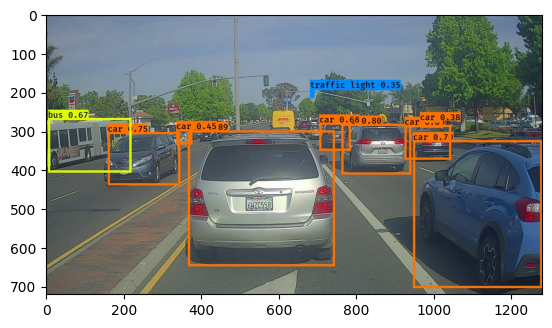

In [29]:
out_scores, out_boxes, out_classes = predict("test.jpg")

Found 4 boxes for images/0001.jpg
car 0.47 (141, 308) (201, 334)
car 0.44 (636, 285) (726, 327)
car 0.36 (547, 296) (594, 316)
car 0.34 (676, 296) (724, 323)


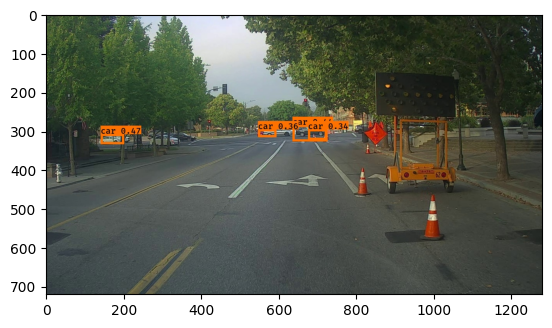

In [43]:
out_scores, out_boxes, out_classes = predict("0001.jpg")

Found 4 boxes for images/0010.jpg
truck 0.66 (736, 266) (1053, 368)
car 0.47 (34, 348) (73, 377)
traffic light 0.37 (746, 138) (787, 188)
traffic light 0.33 (255, 171) (274, 201)


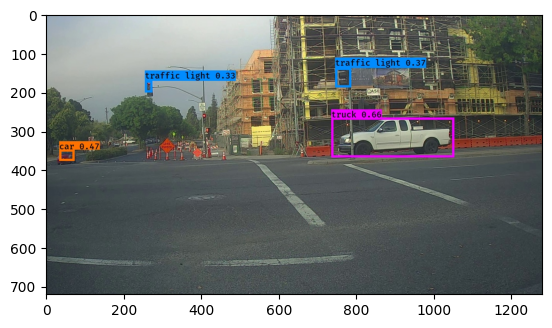

In [44]:
out_scores, out_boxes, out_classes = predict("0010.jpg")

Found 2 boxes for images/0050.jpg
car 0.34 (1261, 295) (1280, 361)
car 0.31 (129, 304) (165, 322)


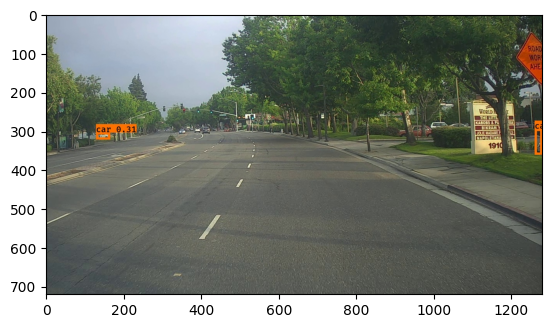

In [45]:
out_scores, out_boxes, out_classes = predict("0050.jpg")

Found 1 boxes for images/0100.jpg
car 0.33 (355, 303) (387, 319)


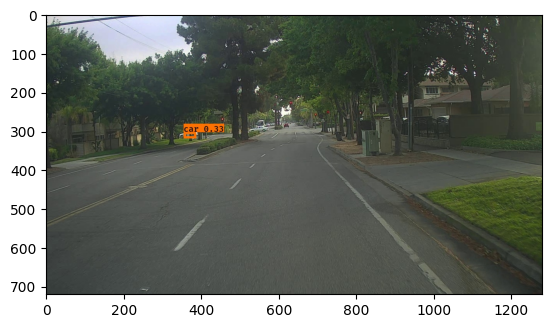

In [46]:
out_scores, out_boxes, out_classes = predict("0100.jpg")

Found 4 boxes for images/0110.jpg
car 0.54 (352, 308) (396, 331)
car 0.38 (126, 329) (183, 370)
car 0.37 (21, 320) (157, 387)
car 0.37 (282, 308) (334, 336)


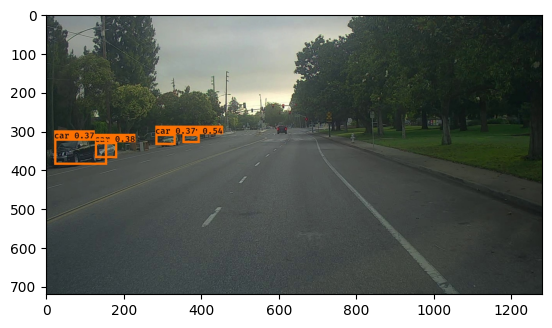

In [47]:
out_scores, out_boxes, out_classes = predict("0110.jpg")

Found 3 boxes for images/0020.jpg
truck 0.75 (538, 286) (926, 413)
traffic light 0.34 (632, 230) (677, 289)
traffic light 0.34 (67, 190) (85, 216)


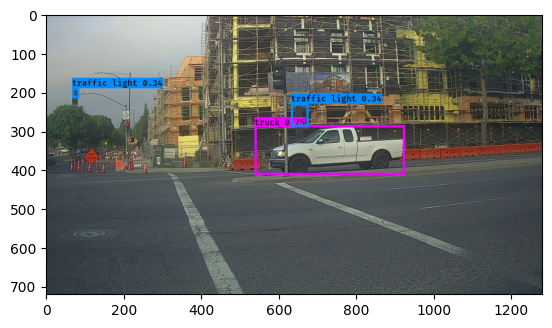

In [49]:
out_scores, out_boxes, out_classes = predict("0020.jpg")

If you were to run your session in a for loop over all your images. Here's what we would get:


<center>
<video width="400" height="200" src="nb_images/pred_video_compressed2.mp4" type="video/mp4" controls>
</video>
</center>

<caption><center> Predictions of the YOLO model on pictures taken from a camera while driving around the Silicon Valley <br> Thanks to <a href="https://www.drive.ai/">drive.ai</a> for providing this dataset! </center></caption>